In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
### Libraries 
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(1, '../codes/')
from myUtils import *
import matplotlib.pyplot as plt
import libpysal

In [2]:
########################## Read city file ###########################################
#
#
idx = 34
fout = '../data_revision/GEE_dataframes/gdf_%d.shp'%idx
gdf_city  = gpd.read_file(fout)

In [3]:
dfc1 = gpd.read_file('../data_revision/cities/all/paris.shp')
dfc1 = dfc1.to_crs("EPSG:4326")

In [ ]:
f,axs=plt.subplots(1,3,figsize=(15,10))

ax=axs[0]
gdf_city.plot(column='NDVI', cmap='Greens',ax=ax, marker='s', vmin=0, vmax=1,
                legend=True, legend_kwds={'shrink': 0.3})
dfc1.boundary.plot(ax=ax,color='red')
vc = 100*gdf_city['NDVI'].sum() / len(gdf_city)
xc = gdf_city['NDVI'].sum() 
ax.set_title('NDVI\n Vegeted area = %d%%, NDVI = %d'%(vc, xc))

ax.axis('off')

ax=axs[1]
gdf_city['ed'] = 0.5*(gdf_city['hot_days']+gdf_city['hot_nights'])/11
gdf_city['hot_days1']=gdf_city['hot_days']/11
gdf_city.plot(column='hot_days1', cmap='hot_r',ax=ax, marker='s', 
                legend=True,legend_kwds={'shrink': 0.3})
dfc1.boundary.plot(ax=ax,color='blue')
vc = gdf_city['ed'].max()
ax.set_title('Hot days and nights\nAverage = %d [(days+nights)/2]'%vc)
ax.axis('off')


gdf_city['ep'] = 0.5*gdf_city['pop']*(gdf_city['hot_days']+gdf_city['hot_nights'])
ax=axs[2]
gdf_city.plot(column='ep', cmap='Blues',ax=ax, marker='s', vmax=1000000, 
                legend=True, legend_kwds={'shrink': 0.3})
vc = gdf_city['ep'].sum()/1e6 
ax.set_title('Total Exposure\n%dM person'%vc+r'$\cdot$'+'days')
dfc1.boundary.plot(ax=ax,color='red')
ax.axis('off')
f.tight_layout()

In [4]:
######## Most populated area of the city: i.e. where the 80% of the population live #############
tmp = gdf_city[['pop','NDVI','geometry']]
tmp = tmp.sort_values(['pop'], ascending=False)
tmp['cs']   = np.cumsum(tmp['pop'])
tmp['css']  = tmp['cs']/tmp['pop'].sum()
tmp=tmp[tmp['css']<=0.8]                                      ###### Focus where the population live

In [ ]:
f,ax=plt.subplots()
tmp.plot(column='pop', cmap='cividis',ax=ax, marker='s',markersize=5,
                legend=True, legend_kwds={'shrink': 0.5})
dfc1.boundary.plot(ax=ax,color='red')
vc = tmp['pop'].sum() 
ax.set_title('Population = %d'%vc)

ax.axis('off')

In [5]:
def incrNDVI(treshold, di, gdf_city):
    mi = treshold - di
    #dfc1 = dfc[dfc.index==idx]
    gdf_city['NDVI_']=gdf_city['NDVI']
    
    idxs1 = np.where(gdf_city['NDVI_']<mi)
    idxs1 = list(idxs1[0])
    
    idxs2 = np.where((gdf_city['NDVI']>=mi) & ((gdf_city['NDVI']<treshold)))
    idxs2 = list(idxs2[0])
                     
    gdf_city['DN'] = 0
    gdf_city['DN'][idxs2]=0.85-gdf_city['NDVI'][idxs2]
                     
    gdf_city['NDVI_'][idxs2] = gdf_city['NDVI_'][idxs2]+gdf_city['DN'][idxs2]
    gdf_city['NDVI_'][idxs1] = gdf_city['NDVI_'][idxs1]+di
    
    return gdf_city

def estimate(target_var, predictor_vars, gdf_city_c, w_test, betas_):
    y_test = gdf_city_c[target_var].values.reshape(-1, 1)
    w_test = libpysal.weights.lag_spatial(w_, y_test)
    x_test = gdf_city_c[predictor_vars].values
    constant = sm.add_constant(np.hstack((x_test,np.array(w_test).reshape(-1,1))))
    ypred_  = np.sum(constant * (betas_.T), axis=1).reshape((-1, 1))
    return ypred_

def exposure(df, col1, col2, pop):
    return (np.sum(df[col1]*df[pop])+np.sum(df[col2]*df[pop]))/2

def norm01(df, column):
    return (df[column] - df[column].min()) / (df[column].max() - df[column].min())

def estimateExposure(predictor_vars,predictor_vars1, target_vars, gdf_city, w_, betas_day, betas_night):
    y_pred_day    = estimate(target_vars[0], predictor_vars, gdf_city, w_, betas_day)
    y_pred_night  = estimate(target_vars[1], predictor_vars, gdf_city, w_, betas_night)
    y_pred_day1   = estimate(target_vars[0], predictor_vars1, gdf_city, w_, betas_day)
    y_pred_night1 = estimate(target_vars[1], predictor_vars1, gdf_city, w_, betas_night)
    
    gdf_city['y_day1']=y_pred_day1
    gdf_city['y_night1']=y_pred_night1

    gdf_city['y_day']=y_pred_day
    gdf_city['y_night']=y_pred_night
    ep1 = exposure(gdf_city, 'y_day1', 'y_night1', 'pop')
    ep = exposure(gdf_city, 'y_day', 'y_night', 'pop')
    
    gdf_city['ep1'] = 0.5*gdf_city['pop']*(gdf_city['y_day1']+gdf_city['y_night1'])
    gdf_city['ep'] = 0.5*gdf_city['pop']*(gdf_city['y_day']+gdf_city['y_night'])
    
    gdf_city['ed1'] = 0.5*(gdf_city['y_day1']+gdf_city['y_night1'])
    gdf_city['ed'] = 0.5*(gdf_city['y_day']+gdf_city['y_night'])
    
    return ep, ep1, gdf_city


def estimateExposure2(predictor_vars,predictor_vars2, target_vars, gdf_city, w_, betas_day, betas_night):
    y_pred_day    = estimate(target_vars[0], predictor_vars, gdf_city, w_, betas_day)
    y_pred_night  = estimate(target_vars[1], predictor_vars, gdf_city, w_, betas_night)
    y_pred_day1 = estimate(target_vars[0], predictor_vars2, gdf_city, w_, betas_day)
    y_pred_night1 = estimate(target_vars[1], predictor_vars2, gdf_city, w_, betas_night)
    
    gdf_city['y_day1']=y_pred_day1
    gdf_city['y_night1']=y_pred_night1

    gdf_city['y_day']=y_pred_day
    gdf_city['y_night']=y_pred_night
    ep1 = exposure(gdf_city, 'y_day1', 'y_night1', 'pop')
    ep = exposure(gdf_city, 'y_day', 'y_night', 'pop')
    
    gdf_city['ep2'] = 0.5*gdf_city['pop']*(gdf_city['y_day1']+gdf_city['y_night1'])
    gdf_city['ep'] = 0.5*gdf_city['pop']*(gdf_city['y_day']+gdf_city['y_night'])
    
    gdf_city['ed2'] = 0.5*(gdf_city['y_day1']+gdf_city['y_night1'])
    gdf_city['ed'] = 0.5*(gdf_city['y_day']+gdf_city['y_night'])
    
    return ep, ep1, gdf_city

In [6]:
betas_day = np.array([3.64209653, -4.67311115, -1.16021593,  0.62546181])
betas_night =  np.array([2.23640437, -2.68122998, -0.59718829,  0.79733414])

In [7]:
################### Try to understand ######################################################
idx = 34
treshold = 0.85
di = 0.3
fout = '../data_revision/GEE_dataframes/gdf_%d.shp'%idx
gdf_city  = gpd.read_file(fout)
gdf_city['hot_days']=gdf_city['hot_days']/11
gdf_city['hot_nights']=gdf_city['hot_nights']/11
gdf_city['dist']=-gdf_city['dist']
gdf_city=gdf_city[gdf_city['dist']>0]
gdf_city['dist_n'] = 1/(gdf_city['dist']**2)
gdf_city['dist_n'] = norm01(gdf_city, 'dist_n')
gdf_city=gdf_city.reset_index(drop=True)


################################# Increase NDVI ##############################################
mi = treshold - di
#dfc1 = dfc[dfc.index==idx]
gdf_city['NDVI_']=gdf_city['NDVI']

idxs1 = np.where(gdf_city['NDVI_']<mi)
idxs1 = list(idxs1[0])

idxs2 = np.where((gdf_city['NDVI']>=mi) & ((gdf_city['NDVI']<treshold)))
idxs2 = list(idxs2[0])

gdf_city['DN'] = 0
gdf_city['DN'][idxs2]=0.85-gdf_city['NDVI'][idxs2]

gdf_city['NDVI_'][idxs2] = gdf_city['NDVI_'][idxs2]+gdf_city['DN'][idxs2]
gdf_city['NDVI_'][idxs1] = gdf_city['NDVI_'][idxs1]+di



In [ ]:
f,axs=plt.subplots(1,2)
gdf_city.plot(column='NDVI', vmax=0.85,ax=axs[0], legend=True, cmap='Greens', legend_kwds={'shrink': 0.3})
gdf_city.plot(column='NDVI_', vmax=0.85,ax=axs[1], legend=True, cmap='Greens', legend_kwds={'shrink': 0.3})
f.tight_layout()

In [ ]:
def estimate(target_var, predictor_vars, gdf_city_c, w_test, betas_):
    y_test = gdf_city_c[target_var].values.reshape(-1, 1)
    w_test = libpysal.weights.lag_spatial(w_, y_test)
    x_test = gdf_city_c[predictor_vars].values
    constant = sm.add_constant(np.hstack((x_test,np.array(w_test).reshape(-1,1))))
    ypred_  = np.sum(constant * (betas_.T), axis=1).reshape((-1, 1))
    return ypred_

In [8]:
target_vars = ['hot_days', 'hot_nights']
predictor_vars = ['NDVI',  'dist_n']
predictor_vars1 = ['NDVI_', 'dist_n']
predictor_vars2 = ['NDVI_a', 'dist_n']

In [9]:
import statsmodels.api as sm

w_ = libpysal.weights.KNN.from_dataframe(gdf_city, k=8)
w_.transform = 'r'
y_pred_day    = estimate(target_vars[0], predictor_vars, gdf_city, w_, betas_day)
y_pred_night  = estimate(target_vars[1], predictor_vars, gdf_city, w_, betas_night)
y_pred_day1   = estimate(target_vars[0], predictor_vars1, gdf_city, w_, betas_day)
y_pred_night1 = estimate(target_vars[1], predictor_vars1, gdf_city, w_, betas_night)

gdf_city['y_day1']=y_pred_day1
gdf_city['y_night1']=y_pred_night1

gdf_city['y_day']=y_pred_day
gdf_city['y_night']=y_pred_night

In [10]:
######## Most populated area of the city: i.e. where the 80% of the population live #############
tmp = gdf_city[['pop','NDVI','geometry']]
tmp = tmp.sort_values(['pop'], ascending=False)
tmp['cs']   = np.cumsum(tmp['pop'])
tmp['css']  = tmp['cs']/tmp['pop'].sum()
tmp=tmp[tmp['css']<=0.8]                                      ###### Focus where the population live

tmp = tmp.sort_values('pop', ascending=False)  
tmp['NDVI_']=tmp['NDVI']+0.38
j = list(np.where(tmp['NDVI_']>0.85)[0])
idx = tmp.index[j]
tmp['NDVI_'][idx]=0.85

gdf_city['NDVI_a']=gdf_city['NDVI']
gdf_city['NDVI_a'][tmp.index]=tmp['NDVI_'][tmp.index]



y_pred_day2   = estimate(target_vars[0], predictor_vars2, gdf_city, w_, betas_day)
y_pred_night2 = estimate(target_vars[1], predictor_vars2, gdf_city, w_, betas_night)
gdf_city['y_day2']=y_pred_day2
gdf_city['y_night2']=y_pred_night2


In [11]:
gdf_city['ep2'] = 0.5*gdf_city['pop']*(gdf_city['y_day2']+gdf_city['y_night2'])
gdf_city['ed2'] = 0.5*(gdf_city['y_day2']+gdf_city['y_day2'])


gdf_city['ep1'] = 0.5*gdf_city['pop']*(gdf_city['y_day1']+gdf_city['y_night1'])
gdf_city['ed1'] = 0.5*(gdf_city['y_day1']+gdf_city['y_day1'])


gdf_city['ep'] = 0.5*gdf_city['pop']*(gdf_city['y_day']+gdf_city['y_night'])
gdf_city['ed'] = 0.5*(gdf_city['y_day']+gdf_city['y_day'])

In [12]:
fs=14

In [ ]:
f,axs = plt.subplots(2, 4, figsize=(20,10))
ax = axs[0][0]
gdf_city.plot(column='pop', vmax=20000,ax=ax, markersize=5,
              legend='True', legend_kwds={'shrink': 0.3}, cmap='cividis', alpha=0.5)
dfc1.boundary.plot(ax=ax,color='black', lw=3)
ax.set_title('Entire urban area', size=fs)
ax.axis('off')


ax = axs[1][0]
tmp.plot(column='pop', vmin=0, vmax=20000,ax=ax, markersize=5,
              legend='True', legend_kwds={'shrink': 0.3}, cmap='cividis', alpha=0.5)
gdf_city.plot(column='pop', vmax=20000,ax=ax,alpha=0)
dfc1.boundary.plot(ax=ax,color='black', lw=3)
ax.set_title('Most populated area', size=fs)
ax.axis('off')

ax = axs[0][1]
gdf_city.plot(column='NDVI', vmin=0, vmax=0.85,ax=ax, markersize=5,
              legend='True', legend_kwds={'shrink': 0.3}, cmap='Greens')
dfc1.boundary.plot(ax=ax,color='black', lw=3)
ax.set_title('Cumulated NDVI\n%.2f'%gdf_city['NDVI'].sum(), size=fs)
ax.axis('off')

ax = axs[1][1]
gdf_city.plot(column='ed', ax=ax, markersize=5, vmax=10, vmin=0,
              legend='True', legend_kwds={'shrink': 0.3}, cmap='hot_r')
dfc1.boundary.plot(ax=ax,color='black')
vc = gdf_city['ep'].sum()/1e6 
ax.set_title(r'$TE_T^0 = %d$'%vc+'M [person'%vc+r'$\cdot$'+'days]', size=fs)
ax.axis('off')


ax = axs[0][2]
gdf_city.plot(column='NDVI_', vmin=0, vmax=0.85,ax=ax, markersize=5,
              legend='True', legend_kwds={'shrink': 0.3}, cmap='Greens')
dfc1.boundary.plot(ax=ax,color='black', lw=3)
ax.set_title('Increased comulated NDVI\n%.2f'%gdf_city['NDVI_'].sum(), size=fs)
ax.axis('off')

ax = axs[1][2]
gdf_city.plot(column='ed1', ax=ax, markersize=5, vmax=10, vmin=0,
              legend='True', legend_kwds={'shrink': 0.3}, cmap='hot_r')
dfc1.boundary.plot(ax=ax,color='black', lw=3)
vc = gdf_city['ep1'].sum()/1e6 
ax.set_title(r'$TE_T^1 = %d$'%vc+'M [person'%vc+r'$\cdot$'+'days]', size=fs)
ax.axis('off')


ax = axs[0][3]
gdf_city.plot(column='NDVI_a', vmin=0, vmax=0.85,ax=ax, markersize=5,
              legend='True', legend_kwds={'shrink': 0.3}, cmap='Greens')
dfc1.boundary.plot(ax=ax,color='black', lw=3)
ax.set_title('Increased comulated NDVI\n%.2f'%gdf_city['NDVI_a'].sum(), size=fs)
ax.axis('off')

ax = axs[1][3]
gdf_city.plot(column='ed2', ax=ax, markersize=5, vmax=10, vmin=0,
              legend='True', legend_kwds={'shrink': 0.3}, cmap='hot_r')
dfc1.boundary.plot(ax=ax,color='black', lw=3)
vc = gdf_city['ep2'].sum()/1e6 
ax.set_title(r'$TE_T^1 = %d$'%vc+'M [person'%vc+r'$\cdot$'+'days]', size=fs)
ax.axis('off')


In [ ]:
f.savefig('../figures_revision/f4SI.pdf', bbox_inches = 'tight')

In [15]:
import sys
import matplotlib.ticker as ticker
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    if a[0]!='0':
        return r'${} $'.format(a[0])
    else:
        return r'${} $'.format('0')
sys.path.insert(1, '../codes/')
from geeCodes import *
S = returnCityBoundary(dfc1)

In [35]:
S[0].to_file('../data_revision/paris_boundary_figure4.shp')

In [36]:
gdf_city.to_file('../data_revision/gdf_city_figure4.shp')

In [37]:
dfc1.to_file('../data_revision/dfc1_figure4.shp')

In [38]:
tmp.to_file('../data_revision/tmp_figure4.shp')

(1.788624288875362, 2.7955821820563735, 48.49629825541558, 49.147016225697264)

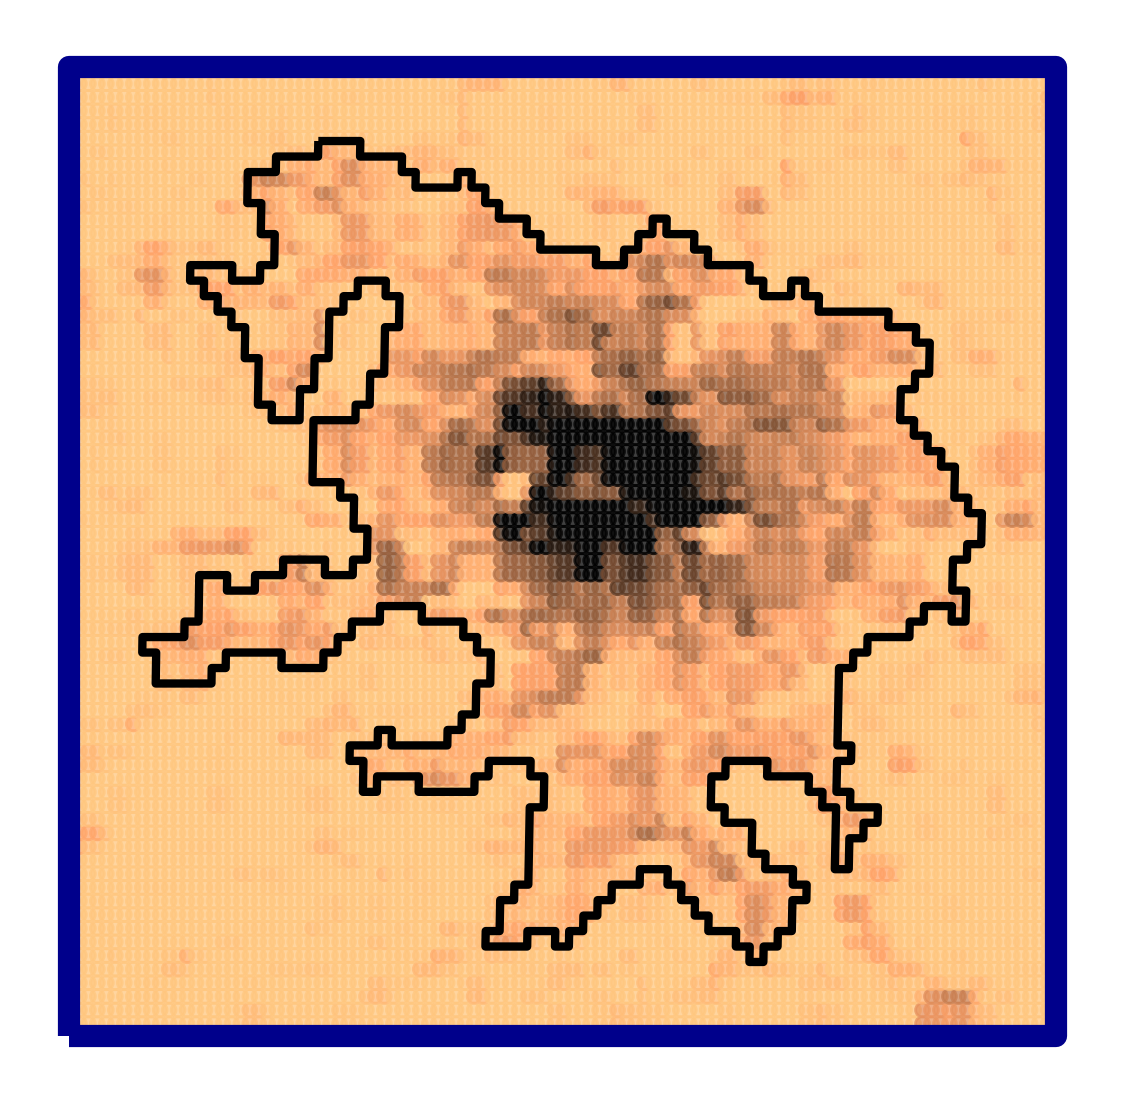

In [27]:
f,ax = plt.subplots(figsize=(7,7))
vmax=20000
vmin=0
gdf_city.plot(column='pop', vmax=20000, vmin=0, ax=ax, markersize=25,
              legend=False, cmap='copper_r', alpha=0.75)
dfc1.boundary.plot(ax=ax,color='black', lw=3)
S[0].boundary.plot(ax=ax, lw=8, color='darkblue')
ax.axis('off')


In [ ]:
f.savefig('../figures_revision/f4an.pdf', bbox_inches = 'tight')

In [ ]:
f,ax = plt.subplots(figsize=(7,7))
tmp.plot(column='pop', ax=ax, markersize=25,legend=False, cmap='copper_r', vmax=20000, vmin=0, alpha=0.75)
gdf_city.plot(column='pop', vmax=20000,ax=ax,alpha=0)
dfc1.boundary.plot(ax=ax,color='black', lw=3)
S[0].boundary.plot(ax=ax, lw=8, color='darkblue')
ax.axis('off')
#f.savefig('../figures_revision/f4bn.pdf', bbox_inches = 'tight')

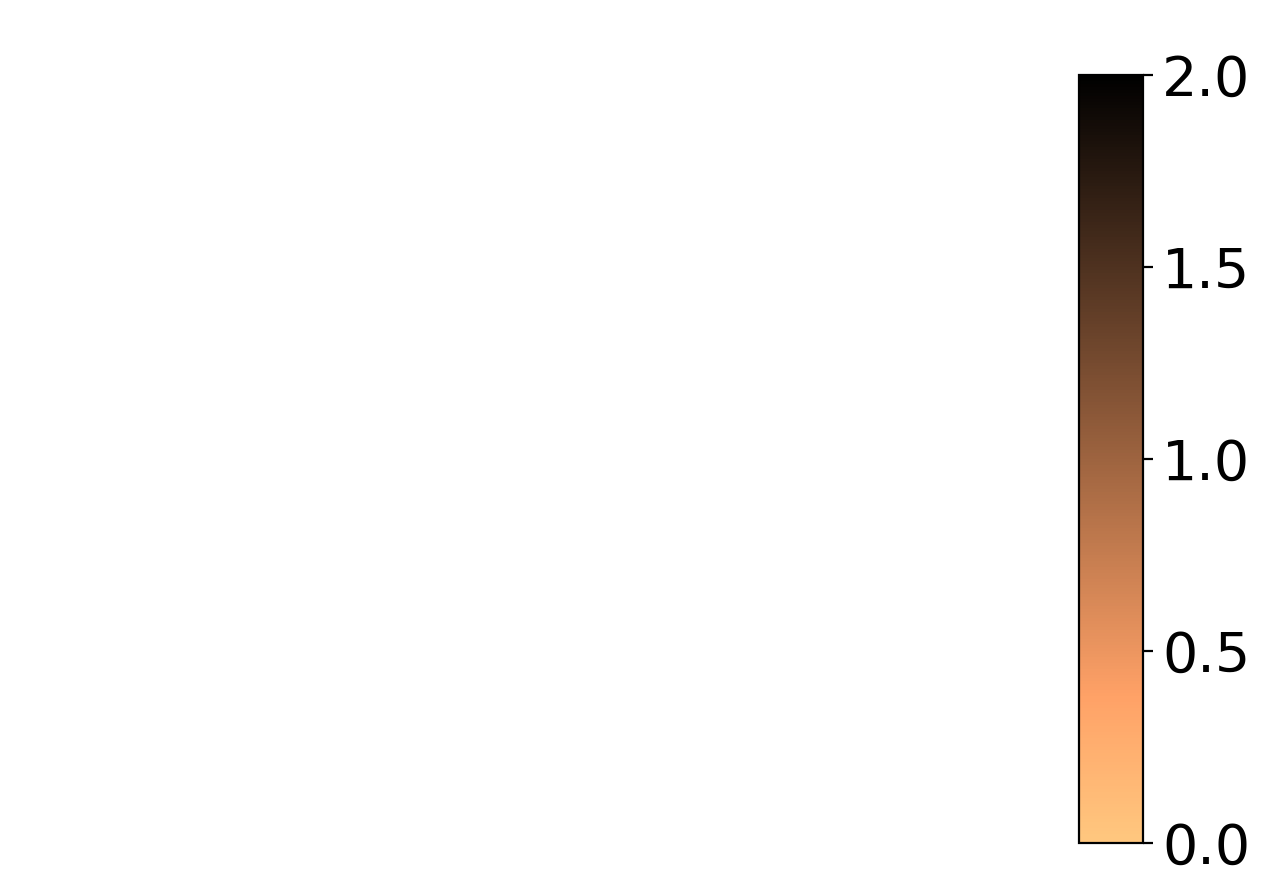

In [28]:
f,ax=plt.subplots()
cax = f.add_axes([0.9, 0.1, 0.05, 0.8])
sm = plt.cm.ScalarMappable(cmap='copper_r', norm=plt.Normalize(vmin=0, vmax=2))
sm._A = []
cbr = f.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=20) 
plt.tight_layout()
ax.axis('off')
f.savefig('../figures_revision/legend4ab.png', bbox_inches = 'tight')

In [ ]:
vmax=0.85
f,ax = plt.subplots(figsize=(7,7))
gdf_city.plot(column='NDVI', vmin=0, vmax=vmax,ax=ax, markersize=25, legend=False, cmap='Greens', alpha=0.75)
#geo.boundary.plot(ax=ax,color='red')
dfc1.boundary.plot(ax=ax,color='black', lw=3)
S[0].boundary.plot(ax=ax, lw=8, color='darkblue')
ax.axis('off')
f.savefig('../figures_revision/ndvi0.pdf', bbox_inches = 'tight')

In [ ]:
f,ax = plt.subplots(figsize=(7,7))
gdf_city.plot(column='NDVI_', vmin=0, vmax=vmax,ax=ax, markersize=25, legend=False, cmap='Greens', alpha=0.75)
dfc1.boundary.plot(ax=ax,color='black', lw=3)
S[0].boundary.plot(ax=ax, lw=8, color='darkblue')
ax.axis('off')
f.savefig('../figures_revision/ndvi1.pdf', bbox_inches = 'tight')

In [ ]:
f,ax = plt.subplots(figsize=(7,7))
gdf_city.plot(column='NDVI_a', vmin=0, vmax=vmax,ax=ax, markersize=25, legend=False, cmap='Greens', alpha=0.75)
dfc1.boundary.plot(ax=ax,color='black', lw=3)
S[0].boundary.plot(ax=ax, lw=8, color='darkblue')
ax.axis('off')
f.savefig('../figures_revision/ndvi2.pdf', bbox_inches = 'tight')

(0.0, 1.0, 0.0, 1.0)

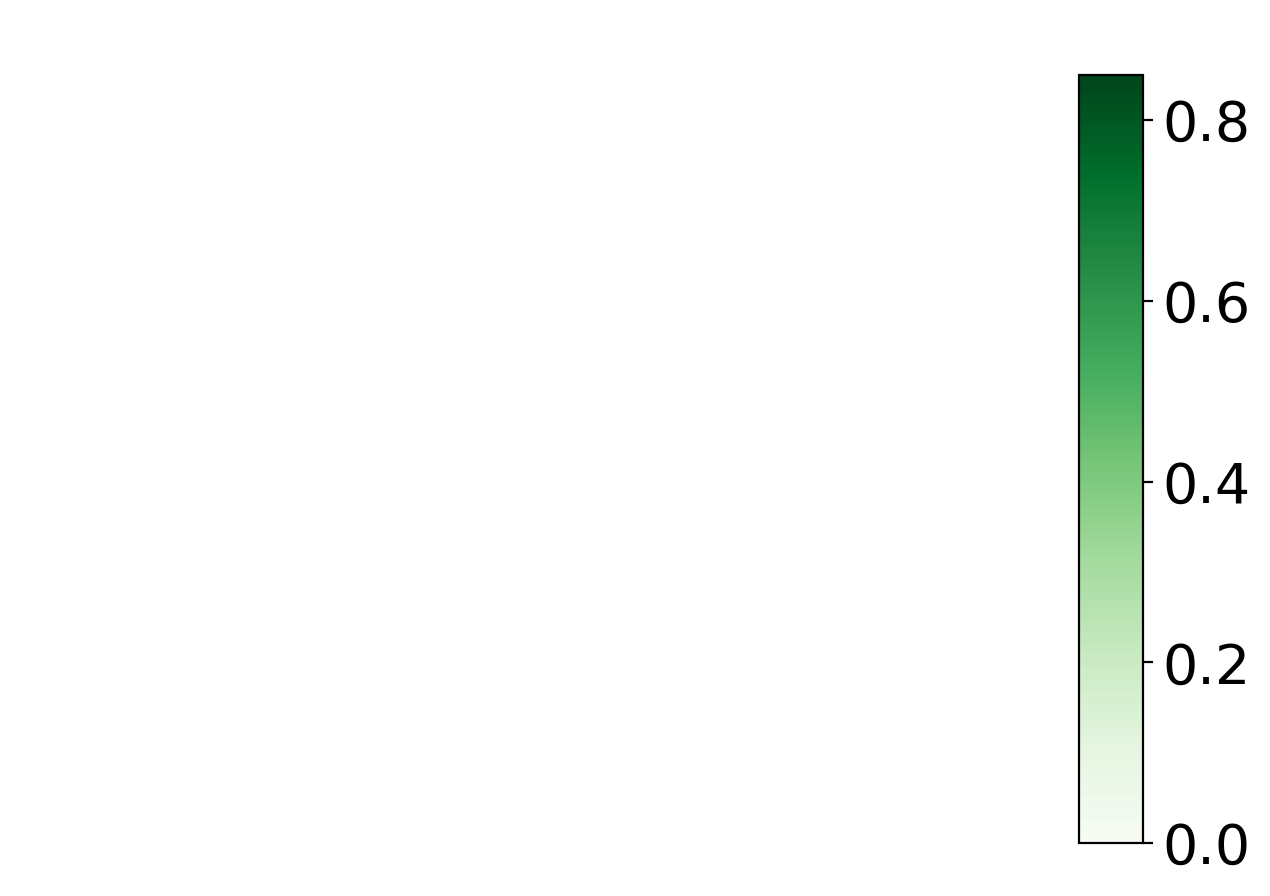

In [29]:
vmax=0.85
f,ax=plt.subplots()
cax = f.add_axes([0.9, 0.1, 0.05, 0.8])
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=0, vmax=vmax))
sm._A = []
cbr = f.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=20) 
plt.tight_layout()
ax.axis('off')

In [30]:
f.savefig('../figures_revision/legend2.png', bbox_inches = 'tight')

In [ ]:
f,ax = plt.subplots(figsize=(7,7))
vmax=40000
vmin=0
cmap = 'gnuplot'
gdf_city.plot(column='pop', ax=ax, markersize=25,legend=False, cmap=cmap, vmax=vmax, vmin=vmin)
dfc1.boundary.plot(ax=ax,color='red')
S[0].boundary.plot(ax=ax, lw=8)
ax.axis('off')
#f.savefig('../figures_revision/f4a.pdf', bbox_inches = 'tight')

In [ ]:
f,ax=plt.subplots()
cax = f.add_axes([0.9, 0.1, 0.05, 0.8])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=4))
sm._A = []
cbr = f.colorbar(sm, cax=cax,format=ticker.FuncFormatter(fmt))
cbr.ax.tick_params(labelsize=20) 
plt.tight_layout()
ax.axis('off')

In [ ]:
f.savefig('../figures_revision/legendaa.pdf', bbox_inches = 'tight')

In [ ]:
f,ax = plt.subplots(figsize=(7,7))
tmp.plot(column='pop', ax=ax, markersize=25,legend=False, cmap=cmap, vmax=vmax)
gdf_city.plot(column='pop', vmax=20000,ax=ax,alpha=0)
geo.boundary.plot(ax=ax,color='red')
S[0].boundary.plot(ax=ax, lw=4)
ax.axis('off')
f.savefig('../figures_revision/f4b.pdf', bbox_inches = 'tight')

In [ ]:
vmax=0.85
f,ax = plt.subplots(figsize=(7,7))
gdf_city.plot(column='NDVI', vmin=0, vmax=vmax,ax=ax, markersize=25, legend=False, cmap='Greens')
geo.boundary.plot(ax=ax,color='red')
S[0].boundary.plot(ax=ax, lw=4)
ax.axis('off')
f.savefig('../figures_revision/ndvi0.pdf', bbox_inches = 'tight')

In [ ]:
f,ax = plt.subplots(figsize=(7,7))
gdf_city.plot(column='NDVI_', vmin=0, vmax=vmax,ax=ax, markersize=25, legend=False, cmap='Greens')
geo.boundary.plot(ax=ax,color='red')
S[0].boundary.plot(ax=ax, lw=4)
ax.axis('off')
f.savefig('../figures_revision/ndvi1.pdf', bbox_inches = 'tight')

In [ ]:
f,ax = plt.subplots(figsize=(7,7))
gdf_city.plot(column='NDVI_a', vmin=0, vmax=vmax,ax=ax, markersize=25, legend=False, cmap='Greens')
geo.boundary.plot(ax=ax,color='red')
S[0].boundary.plot(ax=ax, lw=4)
ax.axis('off')
f.savefig('../figures_revision/ndvi2.pdf', bbox_inches = 'tight')

In [ ]:
f,ax=plt.subplots()
cax = f.add_axes([0.9, 0.1, 0.05, 0.8])
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=0, vmax=vmax))
sm._A = []
cbr = f.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=20) 
plt.tight_layout()
ax.axis('off')

In [ ]:
f.savefig('../figures_revision/legend2.pdf', bbox_inches = 'tight')

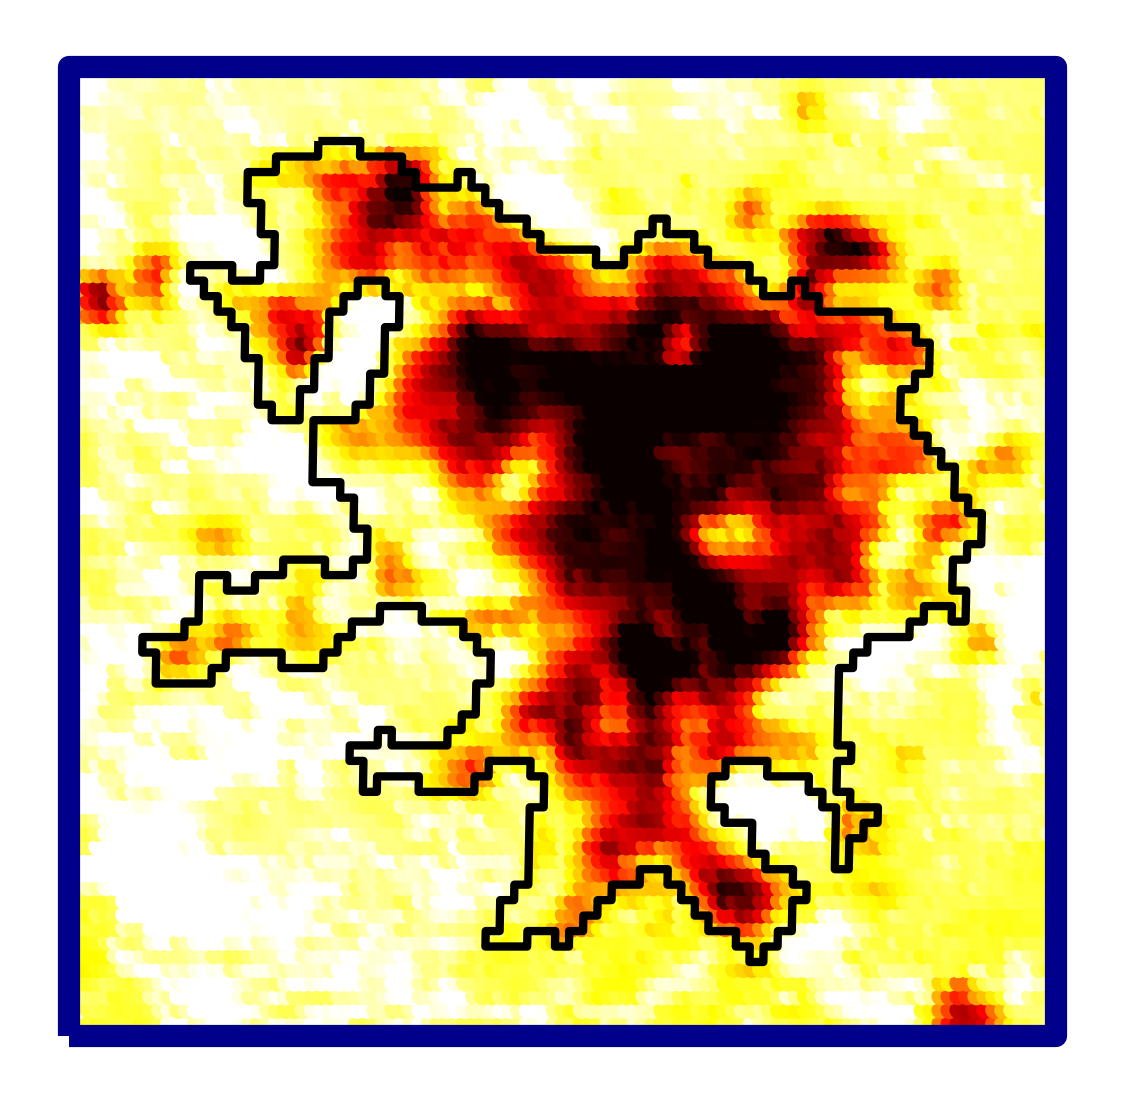

In [18]:
f,ax = plt.subplots(figsize=(7,7))
gdf_city.plot(column='ed', ax=ax, markersize=30, legend=False, cmap='hot_r', vmin=0, vmax=10)
dfc1.boundary.plot(ax=ax,color='black', lw=3)
S[0].boundary.plot(ax=ax, lw=8, color='darkblue')
vc = gdf_city['ep'].sum()/1e6 
ax.axis('off')
f.savefig('../figures_revision/ep1.pdf', bbox_inches = 'tight')

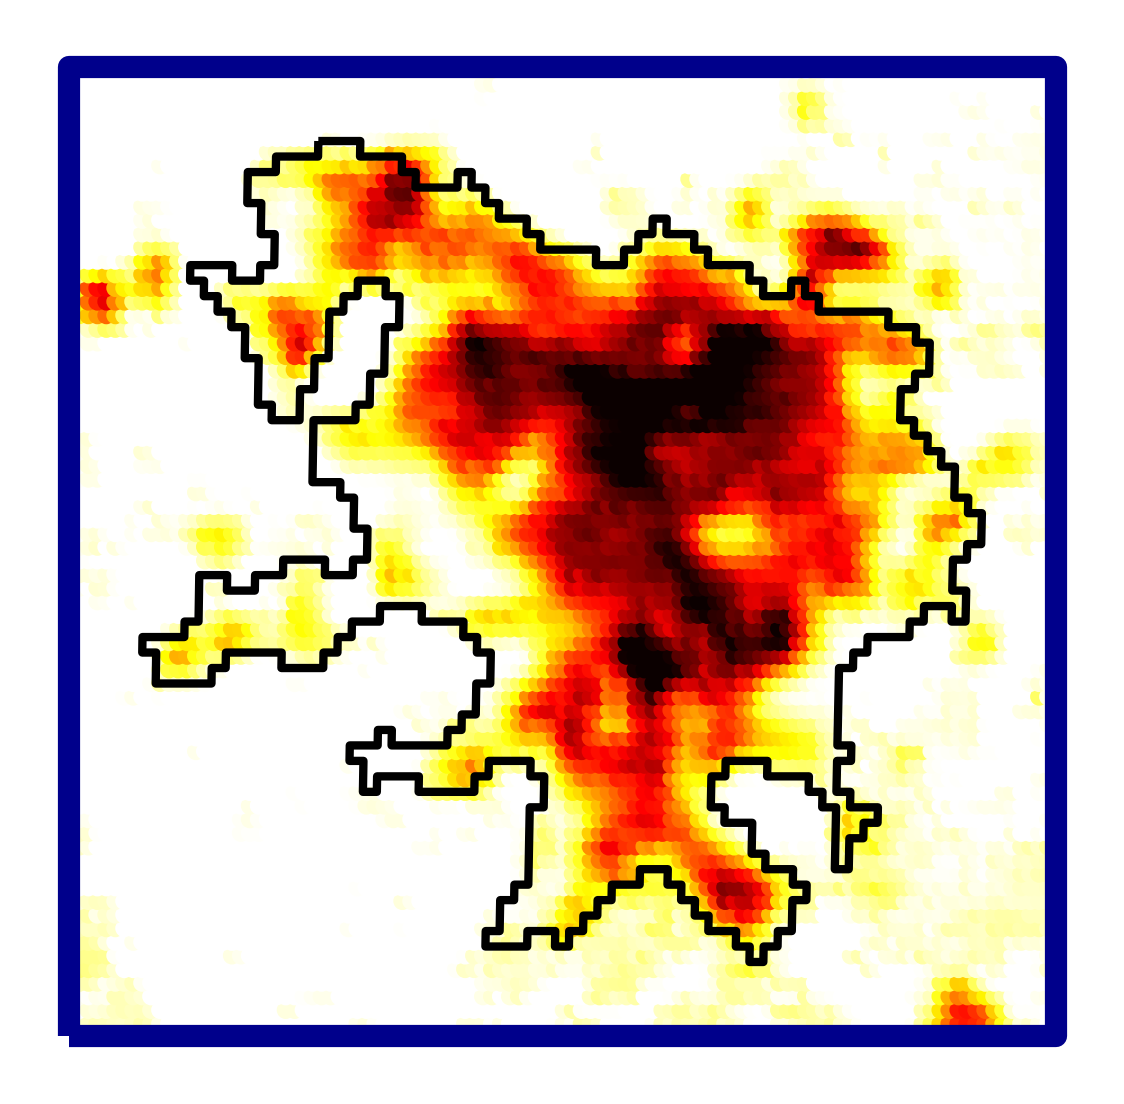

In [19]:
f,ax = plt.subplots(figsize=(7,7))
gdf_city.plot(column='ed1', ax=ax, markersize=30, legend=False, cmap='hot_r', vmin=0, vmax=10)
dfc1.boundary.plot(ax=ax,color='black', lw=3)
S[0].boundary.plot(ax=ax, lw=8, color='darkblue')
vc = gdf_city['ep'].sum()/1e6 
ax.axis('off')
f.savefig('../figures_revision/ep2.pdf', bbox_inches = 'tight')

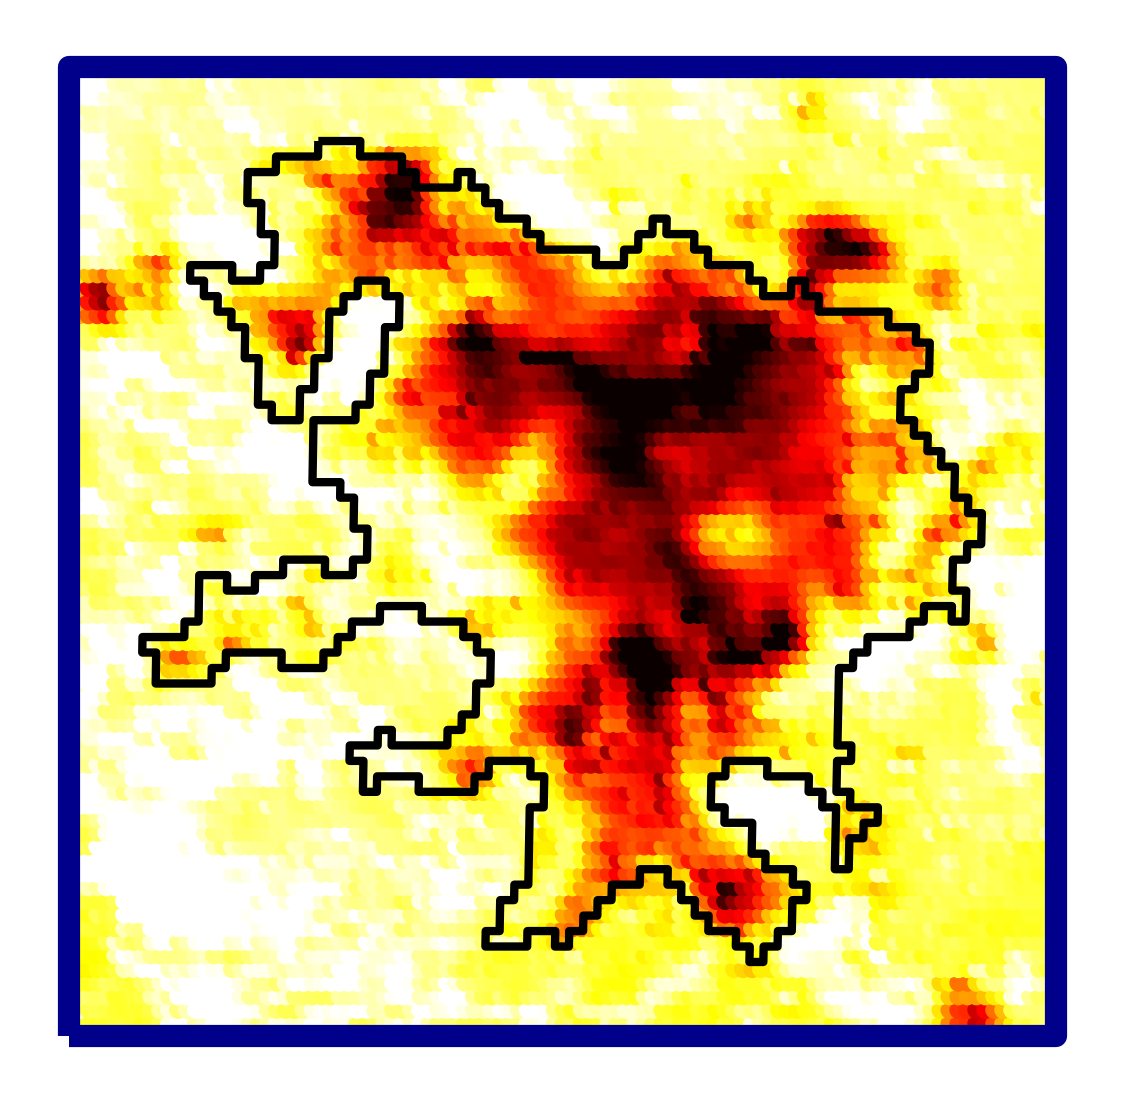

In [20]:
f,ax = plt.subplots(figsize=(7,7))
gdf_city.plot(column='ed2', ax=ax, markersize=30, legend=False, cmap='hot_r', vmin=0, vmax=10)
dfc1.boundary.plot(ax=ax,color='black', lw=3)
S[0].boundary.plot(ax=ax, lw=8, color='darkblue')
vc = gdf_city['ep'].sum()/1e6 
ax.axis('off')
f.savefig('../figures_revision/ep3.pdf', bbox_inches = 'tight')

(0.0, 1.0, 0.0, 1.0)

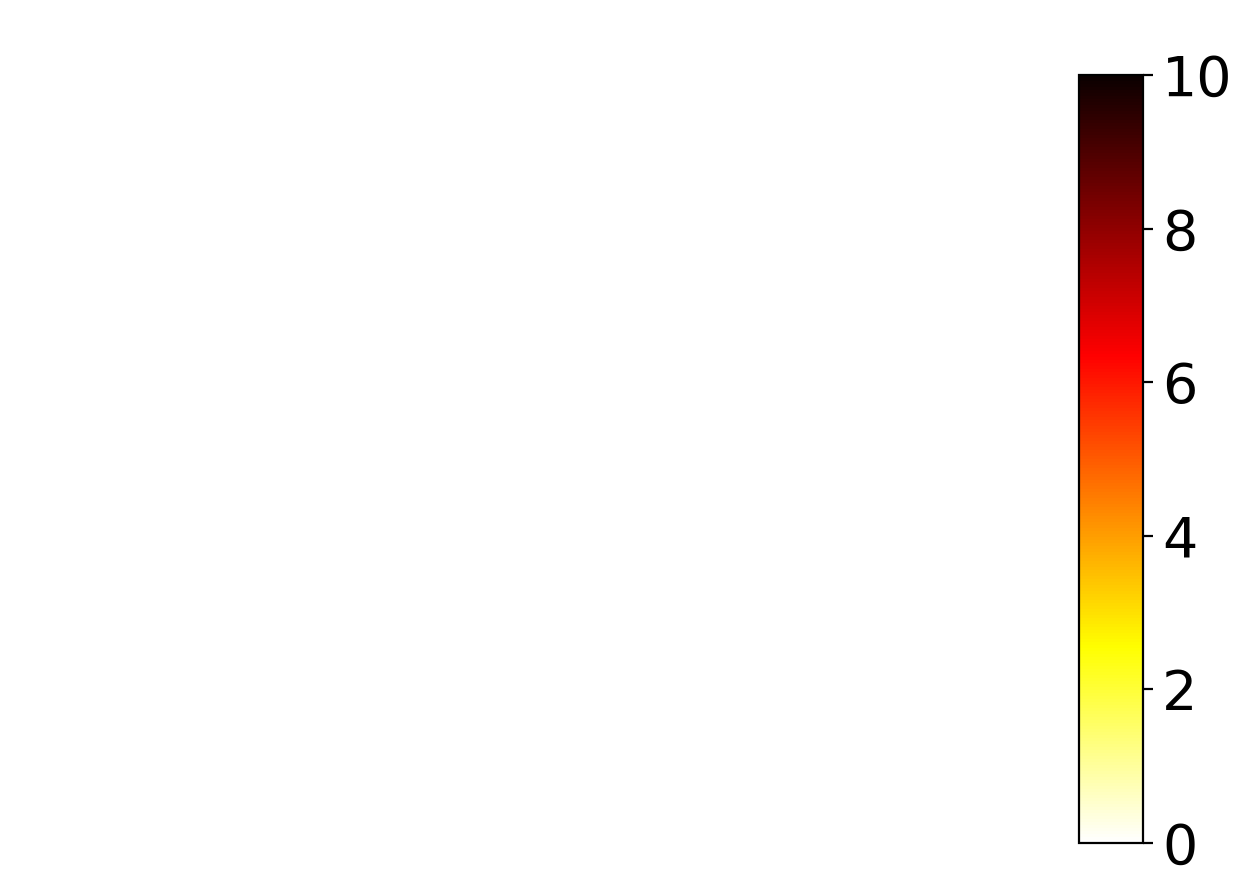

In [23]:
f,ax=plt.subplots()
cax = f.add_axes([0.9, 0.1, 0.05, 0.8])
sm = plt.cm.ScalarMappable(cmap='hot_r', norm=plt.Normalize(vmin=0, vmax=10))
sm._A = []
cbr = f.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=20) 
plt.tight_layout()
ax.axis('off')

In [24]:
f.savefig('../figures_revision/legend3.png', bbox_inches = 'tight')

In [ ]:
f,ax = plt.subplots(figsize=(7,7))
gdf_city.plot(column='ed1', ax=ax, markersize=30, legend=False, cmap='jet', vmin=0, vmax=10)
geo.boundary.plot(ax=ax,color='red')
vc = gdf_city['ep'].sum()/1e6 
S[0].boundary.plot(ax=ax, lw=4)
ax.axis('off')
f.savefig('../figures_revision/ep2.pdf', bbox_inches = 'tight')

In [ ]:
f,ax = plt.subplots(figsize=(7,7))
gdf_city.plot(column='ed2', ax=ax, markersize=30, legend=False, cmap='jet', vmin=0, vmax=10)
geo.boundary.plot(ax=ax,color='red')
vc = gdf_city['ep'].sum()/1e6 
S[0].boundary.plot(ax=ax, lw=4)
ax.axis('off')
f.savefig('../figures_revision/ep3.pdf', bbox_inches = 'tight')

In [ ]:
f,ax=plt.subplots()
cax = f.add_axes([0.9, 0.1, 0.05, 0.8])
sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=10))
sm._A = []
cbr = f.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=20) 
plt.tight_layout()
ax.axis('off')

In [ ]:
f.savefig('../figures_revision/legend3.pdf', bbox_inches = 'tight')

In [ ]:
100*(6201.02 - 4364.15)/4364.15

In [ ]:
6201/4364

In [ ]:
100*(4969.02 - 4364.15)/4364.15